In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

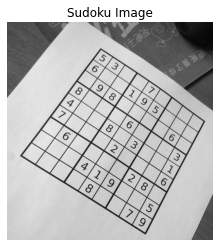

In [2]:
SudokuImgPath = './data/sudoku1.jpg'
img = cv2.imread(SudokuImgPath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(img, cmap='gray'); plt.title('Sudoku Image'); plt.axis('off')
plt.show()

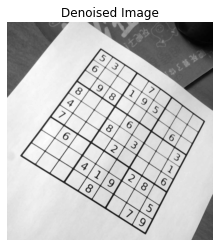

In [3]:
# Denoise.
denoisedImg = cv2.medianBlur(img, 5)
plt.figure()
plt.imshow(denoisedImg, cmap='gray'); plt.title('Denoised Image'); plt.axis('off')
plt.show()

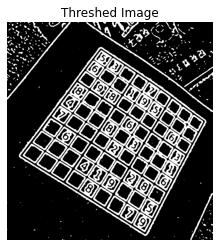

In [4]:
# Threshold to binary.
threshedImg = cv2.adaptiveThreshold(denoisedImg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
threshedImg = cv2.medianBlur(threshedImg, 7)
plt.figure()
plt.imshow(threshedImg, cmap='gray'); plt.title('Threshed Image'); plt.axis('off')
plt.show()

In [5]:
contours, _ = cv2.findContours(threshedImg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda x: cv2.contourArea(x))[::-1]
puzzleContour = contours[0]

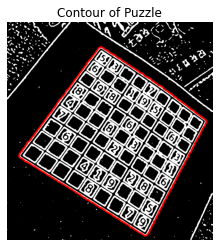

In [6]:
contourImg = cv2.cvtColor(threshedImg, cv2.COLOR_GRAY2BGR)
contourImg = cv2.drawContours(contourImg, [puzzleContour], -1, (255, 0, 0), thickness=5)
plt.figure()
plt.imshow(contourImg); plt.title('Contour of Puzzle'); plt.axis('off')
plt.show()

In [7]:
perimeterContour = cv2.arcLength(puzzleContour, True)
for i in range(0, 100):
    corners = cv2.approxPolyDP(puzzleContour, i / 100.0 * perimeterContour, True)
    if len(corners) == 4:
        break
corners = np.array(corners).squeeze()
corners

array([[353,  94],
       [ 45, 508],
       [524, 810],
       [754, 375]], dtype=int32)

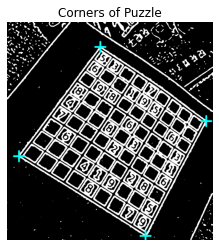

In [8]:
cornerImg = cv2.cvtColor(threshedImg, cv2.COLOR_GRAY2BGR)
for corner in corners:
    cornerImg = cv2.drawMarker(cornerImg, corner, (0, 255, 255), markerType=cv2.MARKER_CROSS, markerSize=40, thickness=5)
plt.figure()
plt.imshow(cornerImg); plt.title('Corners of Puzzle'); plt.axis('off')
plt.show()

In [9]:
edgeLengths = [cv2.arcLength(np.array([corners[i], corners[j]]), False) for (i, j) in [(0, 1), (1, 2), (2, 3), (3, 1)]]
height = width = int(max(edgeLengths))
deskewedPoints = [(0, 0), (width - 1, 0), (width - 1, height - 1), (0, height - 1)] # Anti-clockwise.
deskewedPoints = np.array(deskewedPoints)

def getSkewedPoints(corners):
    '''Anti-clockwise.'''
    sum_ = corners.sum(axis=1)
    diff = -np.diff(corners, axis=1)
    br = corners[np.argmax(sum_)]
    tl = corners[np.argmin(sum_)]
    bl = corners[np.argmin(diff)]
    tr = corners[np.argmax(diff)]
    
    return np.array([tl, tr, br, bl])

skewedPoints = getSkewedPoints(corners)
print('Skewed\n', skewedPoints)
print('Deskewed\n', deskewedPoints)

Skewed
 [[353  94]
 [754 375]
 [524 810]
 [ 45 508]]
Deskewed
 [[  0   0]
 [720   0]
 [720 720]
 [  0 720]]


In [10]:
transform = cv2.getPerspectiveTransform(skewedPoints.astype(np.float32), deskewedPoints.astype(np.float32))
transform

array([[ 1.05034206e+00,  7.81413901e-01, -4.44223655e+02],
       [-8.68748406e-01,  1.23974417e+00,  1.90132236e+02],
       [-2.39205110e-04,  1.87496828e-04,  1.00000000e+00]])

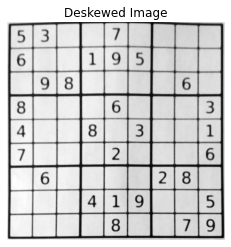

In [11]:
deskewedImg = cv2.warpPerspective(denoisedImg, transform, (width, height))
plt.figure()
plt.imshow(deskewedImg, cmap='gray'); plt.title('Deskewed Image'); plt.axis('off')
plt.show()